# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=70,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-03-50/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4764 | MulticlassF1Score=0.1545
Batch-30 : CrossEntropyLoss=2.4786 | MulticlassF1Score=0.2022
Batch-45 : CrossEntropyLoss=2.4892 | MulticlassF1Score=0.2219
Batch-60 : CrossEntropyLoss=2.4296 | MulticlassF1Score=0.2477
Batch-75 : CrossEntropyLoss=2.4346 | MulticlassF1Score=0.2760
Batch-90 : CrossEntropyLoss=2.4152 | MulticlassF1Score=0.3055
Batch-105: CrossEntropyLoss=2.4050 | MulticlassF1Score=0.3302
Batch-120: CrossEntropyLoss=2.3983 | MulticlassF1Score=0.3483
Batch-135: CrossEntropyLoss=2.3759 | MulticlassF1Score=0.3646
Batch-150: CrossEntropyLoss=2.3643 | MulticlassF1Score=0.3870
Batch-165: CrossEntropyLoss=2.3678 | MulticlassF1Score=0.4065
Batch-180: CrossEntropyLoss=2.3620 | MulticlassF1Score=0.4219
Batch-195: CrossEntropyLoss=2.3661 | MulticlassF1Score=0.4408
Batch-210: CrossEntropyLoss=2.3545 | MulticlassF1Score=0.4577
Batch-225: CrossEntropyLoss=2.3578 | MulticlassF1Score=0.4720
Batch-226: CrossEntropyLoss=2.3407 | MulticlassF1Score=0.4726

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3682 | MulticlassF1Score=0.6654
Batch-30 : CrossEntropyLoss=2.3705 | MulticlassF1Score=0.6701
Batch-45 : CrossEntropyLoss=2.3355 | MulticlassF1Score=0.6734
Batch-60 : CrossEntropyLoss=2.3430 | MulticlassF1Score=0.6761
Batch-63 : CrossEntropyLoss=2.3572 | MulticlassF1Score=0.6758

Training   : Mean CrossEntropyLoss = 2.4218 | Mean MulticlassF1Score = 0.3235
Validation : Mean CrossEntropyLoss = 2.3491 | Mean MulticlassF1Score = 0.6702

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3464 | MulticlassF1Score=0.6746
Batch-30 : CrossEntropyLoss=2.3361 | MulticlassF1Score=0.6752
Batch-45 : CrossEntropyLoss=2.3701 | MulticlassF1Score=0.6750
Batch-60 : CrossEntropyLoss=2.3350 | MulticlassF1Score=0.6902
Batch-75 : CrossEntropyLoss=2.3252 | MulticlassF1Score=0.7057
Batch-90 : CrossEntropyLoss=2.3162 | MulticlassF1Score=0.7152
Batch-105: CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7242
Batch-120: CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7326
Batch-135: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7385
Batch-150: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7433
Batch-165: CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7475
Batch-180: CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7507
Batch-195: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7538
Batch-210: CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7566
Batch-225: CrossEntropyLoss=2.3206 | MulticlassF1Score=0.7591
Batch-226: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7592

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.7891
Batch-30 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7930
Batch-45 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.7921
Batch-60 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7908
Batch-63 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7917

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3236 | Mean MulticlassF1Score = 0.7201
Validation : Mean CrossEntropyLoss = 2.3126 | Mean MulticlassF1Score = 0.7903

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3158 | MulticlassF1Score=0.8019
Batch-30 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.7982
Batch-45 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7978
Batch-60 : CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7970
Batch-75 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.7956
Batch-90 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.7948
Batch-105: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7945
Batch-120: CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7936
Batch-135: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7937
Batch-150: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.7942
Batch-165: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7940
Batch-180: CrossEntropyLoss=2.3278 | MulticlassF1Score=0.7941
Batch-195: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7939
Batch-210: CrossEntropyLoss=2.3157 | MulticlassF1Score=0.7943
Batch-225: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7943
Batch-226: CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7944

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7939
Batch-30 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.7944
Batch-45 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7964
Batch-60 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7946
Batch-63 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7941

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3117 | Mean MulticlassF1Score = 0.7959
Validation : Mean CrossEntropyLoss = 2.3115 | Mean MulticlassF1Score = 0.7929

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8000
Batch-30 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.7982
Batch-45 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8026
Batch-60 : CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8035
Batch-75 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8044
Batch-90 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.8052
Batch-105: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8054
Batch-120: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8065
Batch-135: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.8060
Batch-150: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8079
Batch-165: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8094
Batch-180: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8108
Batch-195: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8118
Batch-210: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8127
Batch-225: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8134
Batch-226: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8136

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8240
Batch-30 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8235
Batch-45 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8244
Batch-60 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8259
Batch-63 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8261

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3057 | Mean MulticlassF1Score = 0.8061
Validation : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8243

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8258
Batch-30 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8263
Batch-45 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8264
Batch-60 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8274
Batch-75 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8275
Batch-90 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8279
Batch-105: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8279
Batch-120: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8285
Batch-135: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8283
Batch-150: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8285
Batch-165: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8288
Batch-180: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8289
Batch-195: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8286
Batch-210: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8286
Batch-225: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8292
Batch-226: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8293

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8313
Batch-30 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.8306
Batch-45 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8289
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8277
Batch-63 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8279

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8277
Validation : Mean CrossEntropyLoss = 2.3009 | Mean MulticlassF1Score = 0.8303

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8324
Batch-30 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8327
Batch-45 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8331
Batch-60 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8334
Batch-75 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8334
Batch-90 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8333
Batch-105: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8328
Batch-120: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8322
Batch-135: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8318
Batch-150: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8319
Batch-165: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8316
Batch-180: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8319
Batch-195: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8322
Batch-210: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8321
Batch-225: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8319
Batch-226: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8319

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8301
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8302
Batch-45 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8309
Batch-60 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8304
Batch-63 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8300

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2998 | Mean MulticlassF1Score = 0.8323
Validation : Mean CrossEntropyLoss = 2.3003 | Mean MulticlassF1Score = 0.8300

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8308
Batch-30 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8366
Batch-45 : CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8337
Batch-60 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8356
Batch-75 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8350
Batch-90 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8348
Batch-105: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8348
Batch-120: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8342
Batch-135: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8353
Batch-150: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8362
Batch-165: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8374
Batch-180: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8378
Batch-195: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8386
Batch-210: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8390
Batch-225: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8394
Batch-226: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8492
Batch-30 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8451
Batch-45 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8453
Batch-60 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8455
Batch-63 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8455

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2976 | Mean MulticlassF1Score = 0.8359
Validation : Mean CrossEntropyLoss = 2.2957 | Mean MulticlassF1Score = 0.8470

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8511
Batch-30 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8498
Batch-45 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8503
Batch-60 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8506
Batch-75 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8504
Batch-90 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8514
Batch-105: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8526
Batch-120: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8530
Batch-135: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8530
Batch-150: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8523
Batch-165: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8516
Batch-180: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8511
Batch-195: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8514
Batch-210: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8513
Batch-225: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8513
Batch-226: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8513

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8456
Batch-30 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8457
Batch-45 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8475
Batch-60 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8471
Batch-63 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8472

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2939 | Mean MulticlassF1Score = 0.8514
Validation : Mean CrossEntropyLoss = 2.2951 | Mean MulticlassF1Score = 0.8463

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8529
Batch-30 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8536
Batch-45 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8532
Batch-60 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8529
Batch-75 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8526
Batch-90 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8523
Batch-105: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8517
Batch-120: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8531
Batch-135: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8524
Batch-150: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8527
Batch-165: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8533
Batch-180: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8541
Batch-195: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8548
Batch-210: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8553
Batch-225: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8556
Batch-226: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8557

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8574
Batch-30 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8552
Batch-45 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8557
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8541
Batch-63 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8546

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2924 | Mean MulticlassF1Score = 0.8531
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8568

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8592
Batch-30 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8603
Batch-45 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8624
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8615
Batch-75 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8609
Batch-90 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8607
Batch-105: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8611
Batch-120: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8605
Batch-135: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8606
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8610
Batch-165: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8616
Batch-180: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8621
Batch-195: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8620
Batch-210: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8621
Batch-225: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8621
Batch-226: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8621

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8544
Batch-30 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8546
Batch-45 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8555
Batch-60 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8563
Batch-63 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8565

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2904 | Mean MulticlassF1Score = 0.8608
Validation : Mean CrossEntropyLoss = 2.2920 | Mean MulticlassF1Score = 0.8556

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8676
Batch-30 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8674
Batch-45 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8670
Batch-60 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8653
Batch-75 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8645
Batch-90 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8643
Batch-105: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8642
Batch-120: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8649
Batch-135: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8645
Batch-150: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8647
Batch-165: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8645
Batch-180: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8654
Batch-195: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8653
Batch-210: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8657
Batch-225: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8666
Batch-226: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8775
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8791
Batch-45 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8780
Batch-60 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8779
Batch-63 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8777

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2889 | Mean MulticlassF1Score = 0.8652
Validation : Mean CrossEntropyLoss = 2.2861 | Mean MulticlassF1Score = 0.8769

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8889
Batch-45 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8892
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8913
Batch-75 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8920
Batch-90 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8929
Batch-105: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8942
Batch-120: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8946
Batch-135: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8954
Batch-150: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8959
Batch-165: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8959
Batch-180: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8959
Batch-195: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8958
Batch-210: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8956
Batch-225: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8958
Batch-226: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8957

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8907
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8895
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8892
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8901
Batch-63 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8897

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8932
Validation : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8898

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9017
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9000
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9012
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9010
Batch-75 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.9006
Batch-90 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9006
Batch-105: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9015
Batch-120: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9011
Batch-135: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9009
Batch-150: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9013
Batch-165: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9014
Batch-180: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9011
Batch-195: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9016
Batch-210: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9014
Batch-225: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9013
Batch-226: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9014

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8935
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8925
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8919
Batch-63 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8916

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2783 | Mean MulticlassF1Score = 0.9013
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8935

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9052
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9068
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9063
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9057
Batch-75 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9049
Batch-90 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9042
Batch-105: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9048
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9039
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9037
Batch-150: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9038
Batch-165: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9036
Batch-180: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9039
Batch-195: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9041
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9042
Batch-225: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9041
Batch-226: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9041

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8942
Batch-30 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8930
Batch-45 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8925
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8919
Batch-63 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8919

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2775 | Mean MulticlassF1Score = 0.9047
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8922

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9051
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9025
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9036
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9042
Batch-75 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9042
Batch-90 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.9042
Batch-105: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9045
Batch-120: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9050
Batch-135: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.9048
Batch-150: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9045
Batch-165: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9047
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9053
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9062
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9078
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9090
Batch-226: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9091

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9173
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9144
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9154
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9157
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9160

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.9048
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9154

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9324
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9323
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9322
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9337
Batch-75 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9336
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9342
Batch-105: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9344
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9345
Batch-135: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9346
Batch-150: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9347
Batch-165: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9345
Batch-180: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9344
Batch-195: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9342
Batch-210: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9341
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9341
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9341

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9215
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9207
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9218

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9338
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9202

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9347
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9364
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9363
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9362
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9369
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9367
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9366
Batch-135: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9373
Batch-165: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9370
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9367
Batch-210: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9366
Batch-225: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9366
Batch-226: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9365

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9202
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9218
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9218

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9367
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9216

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9363
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9399
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9388
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9377
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9376
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9380
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9381
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9382
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9380
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9379
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9379
Batch-210: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9376
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9209
Batch-30 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9212
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9217
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9216

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9378
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9212

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9369
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9371
Batch-60 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9376
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9370
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9379
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9385
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9385
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9383
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9381
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9382
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9384
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9384

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9213
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9195
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9209
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9212

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9379
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9215

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9394
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9399
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9397
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9398
Batch-90 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9397
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9393
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9395
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9394
Batch-180: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9393
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9393
Batch-210: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9393
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9391
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9221

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9397
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9237

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9377
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9392
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9393
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9391
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9389
Batch-165: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9393
Batch-180: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9394
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9392
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9393
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9394
Batch-226: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9232
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9224

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9394
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9236

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9398
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9407
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9404
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9406
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9405
Batch-150: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9409
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9406
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9403
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9403
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9401
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9401
Batch-226: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9400

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9213
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9214

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9222

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9417
Batch-75 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9412
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9408
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9406
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9404
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9403
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9405
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9404
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9405
Batch-210: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9407
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9407
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9407

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9205
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9227
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9220

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9222

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9406
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9398
Batch-75 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9398
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9396
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9399
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9404
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9409
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9411
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9410
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9216
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9223

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9408
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9218

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9432
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9431
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9430
Batch-105: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9429
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9425
Batch-150: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9423
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9424
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9423
Batch-195: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9420
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9417
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9419
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9419

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9229

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9234

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9418
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9413
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9438
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9437
Batch-150: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9433
Batch-165: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9426
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9280
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9234

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9427
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9262

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9427
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9430
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9432
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9427
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9427
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9219
Batch-30 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9216
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9234

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9228

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9438
Batch-105: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9440
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9433
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9428
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9430
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9432
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9430
Batch-226: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9233
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9236

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9437
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9244

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9418
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9424
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9431
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9433
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9433
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9434
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9431
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9428

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9244
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9233

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9431
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9244
Patience = 1/50‚ùó

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9434
Batch-75 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9433
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9429
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9428
Batch-120: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9426
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9428
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9428
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9427
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9427
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9429
Batch-225: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9216

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9238

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9450
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9440
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9434
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9432
Batch-195: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9432
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9432
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9431
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9208
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9213

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9233

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9436
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9434
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9434

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9223
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9228

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9228

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9433
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9425
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9434
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9436
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9439
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9437
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9439
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9438

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9221
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9220
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9225

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9218

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9445
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9446
Batch-150: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9445
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9247
Batch-63 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9241

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9451
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9247

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9454
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9456
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9452
Batch-120: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9450
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9442
Batch-165: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9441
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9207
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9235

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9445
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9215

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9469
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9458
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9452
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9450
Batch-210: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9451
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9451
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9238
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9239

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9462
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9223

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9446
Batch-75 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9454
Batch-105: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9453
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9458
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9456
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9470
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9479
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9480

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9396
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9395
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9418
Batch-63 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9420

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9395

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9646
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9626
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9621
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9634
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9642
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9640
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9640
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9642
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9643
Batch-150: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9643
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9641
Batch-180: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9639
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9639
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9639
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9445

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9637
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9450

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9627
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9649
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9652
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9652
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9654
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9659
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9664
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9667
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9671
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9667
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9669
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9469

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9659
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9468

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9654
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9672
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9682
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9521
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9493

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9503

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9704
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9704
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9496
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9495

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9491

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9710
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9708
Batch-180: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9708
Batch-226: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9708

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9515
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9499
Batch-63 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9497

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9505

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9715
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9722
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9722
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9724
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9722
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9721
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9720
Batch-135: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9716
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9497
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9496

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9719
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9487

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2512 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9722
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9730
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9726
Batch-75 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9723
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9718
Batch-120: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9719
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9718
Batch-150: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9720
Batch-180: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9718
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9498
Batch-63 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9497

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9488

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9737
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9737
Batch-45 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9738
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9728
Batch-75 : CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9724
Batch-90 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9725
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9726
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9725
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9723
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9722
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9719
Batch-180: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9722
Batch-195: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9720
Batch-210: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9719
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9718
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9497

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9726
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9484

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9716
Batch-30 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9719
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9721
Batch-105: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9719
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9718
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9719
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9718
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9718
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9718
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9509
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9502
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9498

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9491
Patience = 2/50‚ùó

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9733
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9728
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9722
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9723
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9728
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9728
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9724
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9725
Batch-150: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9726
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9726
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9725
Batch-195: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9723
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9720
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9718
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9505
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9503
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9499

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9724
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9492

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9718
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9720
Batch-60 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9720
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9722
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9717
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9716
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9716
Batch-180: CrossEntropyLoss=2.2513 | MulticlassF1Score=0.9716
Batch-195: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9717
Batch-210: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9719
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9719

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9529
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9495

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9716
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9511
Patience = 3/50‚ùó

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9724
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9728
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9727
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9722
Batch-90 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9724
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9725
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9723
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9721
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9721
Batch-165: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9721
Batch-180: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9718
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9718
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9717
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9717

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9497

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9720
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9492
Patience = 4/50‚ùó

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9707
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9715
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9717
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9715
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9716
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9714
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9712
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9513
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9498
Batch-63 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9502

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9513
Patience = 5/50‚ùó

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2562
Best CrossEntropyLoss training    : 2.2630
Best MulticlassF1Score validation : 0.9724
Best MulticlassF1Score validation : 0.9492
Training duration                 : 1.9981 minutes.
Training date                     : 2022-10-19 12:38:58.368270+08:00


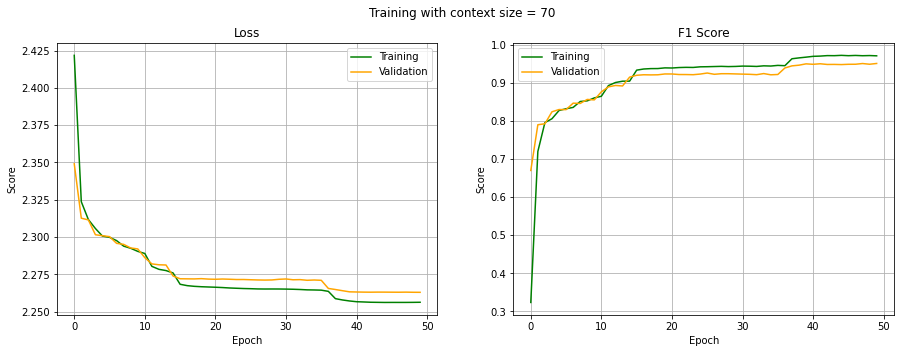

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9723, device='cuda:0'),
 tensor(0.9502, device='cuda:0'),
 tensor(0.9499, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9723, device='cuda:0'),
 tensor(0.9502, device='cuda:0'),
 tensor(0.9499, device='cuda:0'))

## Heatmap

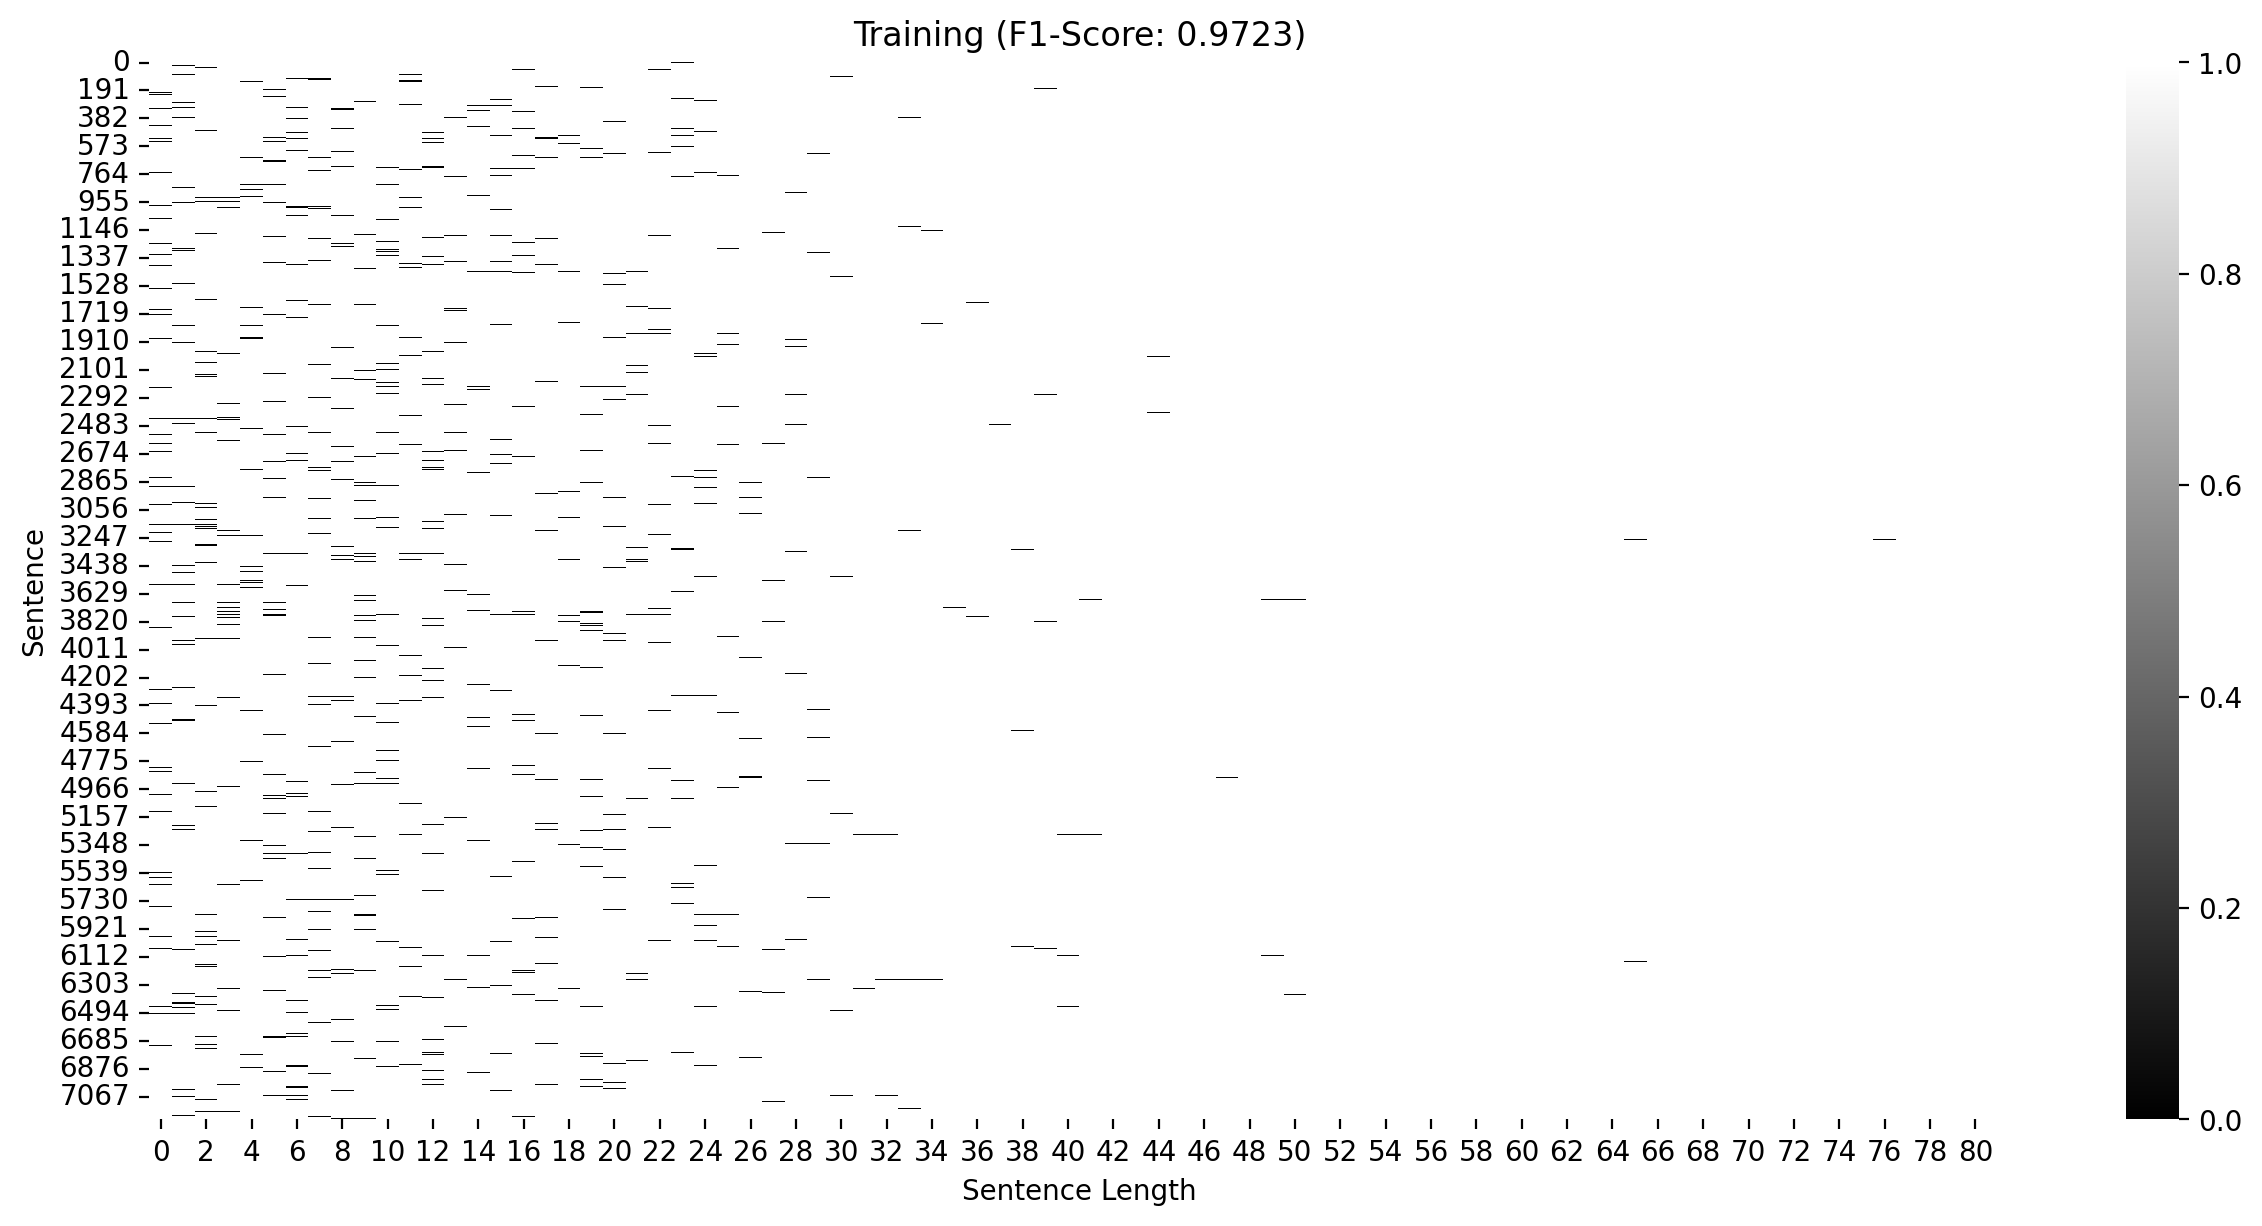

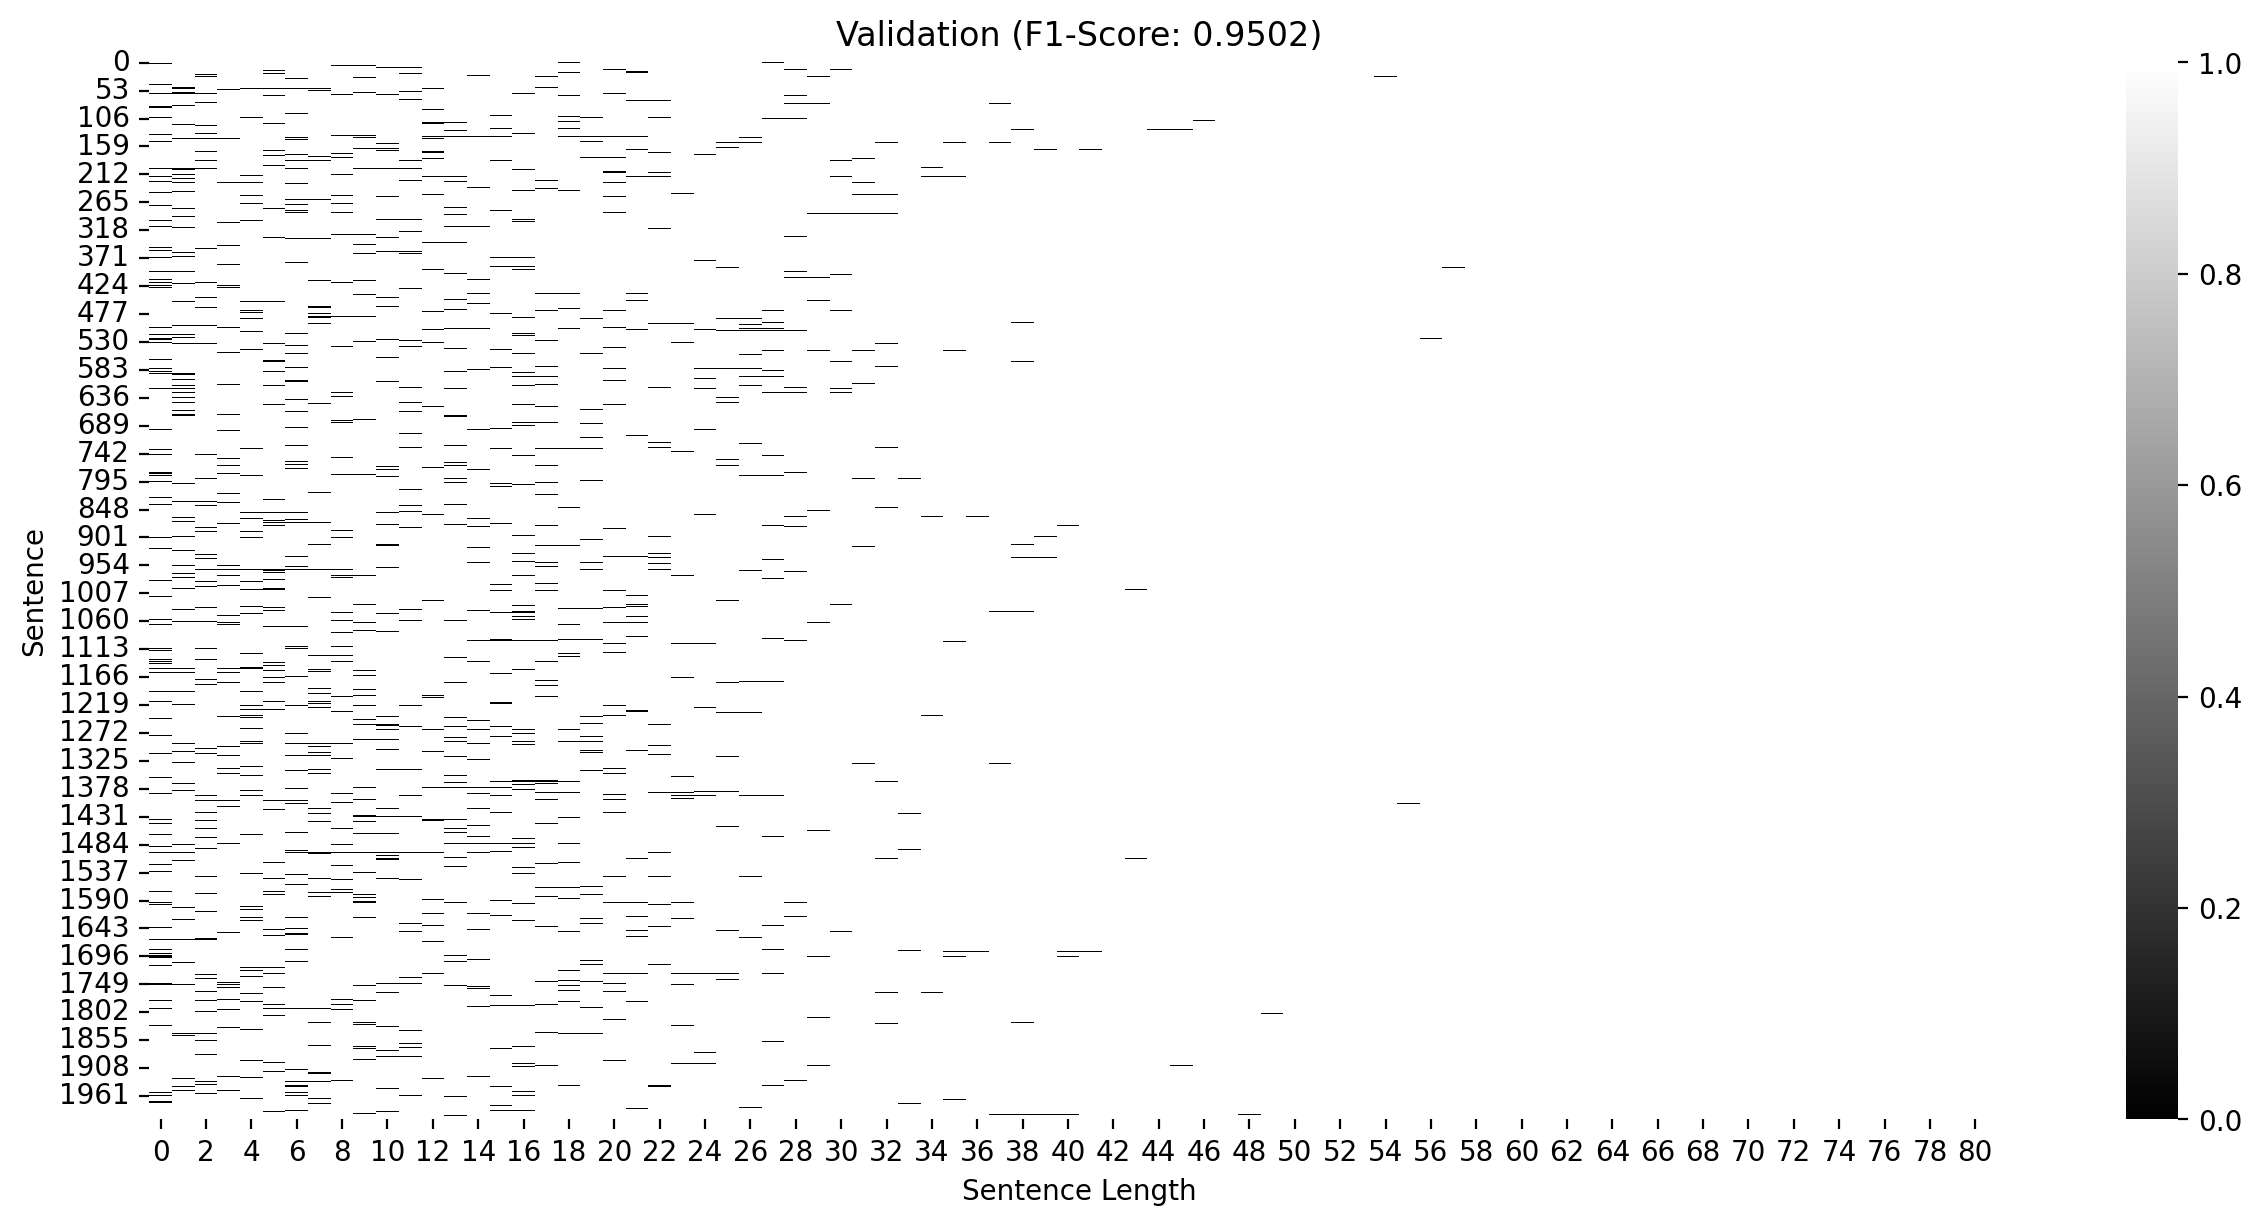

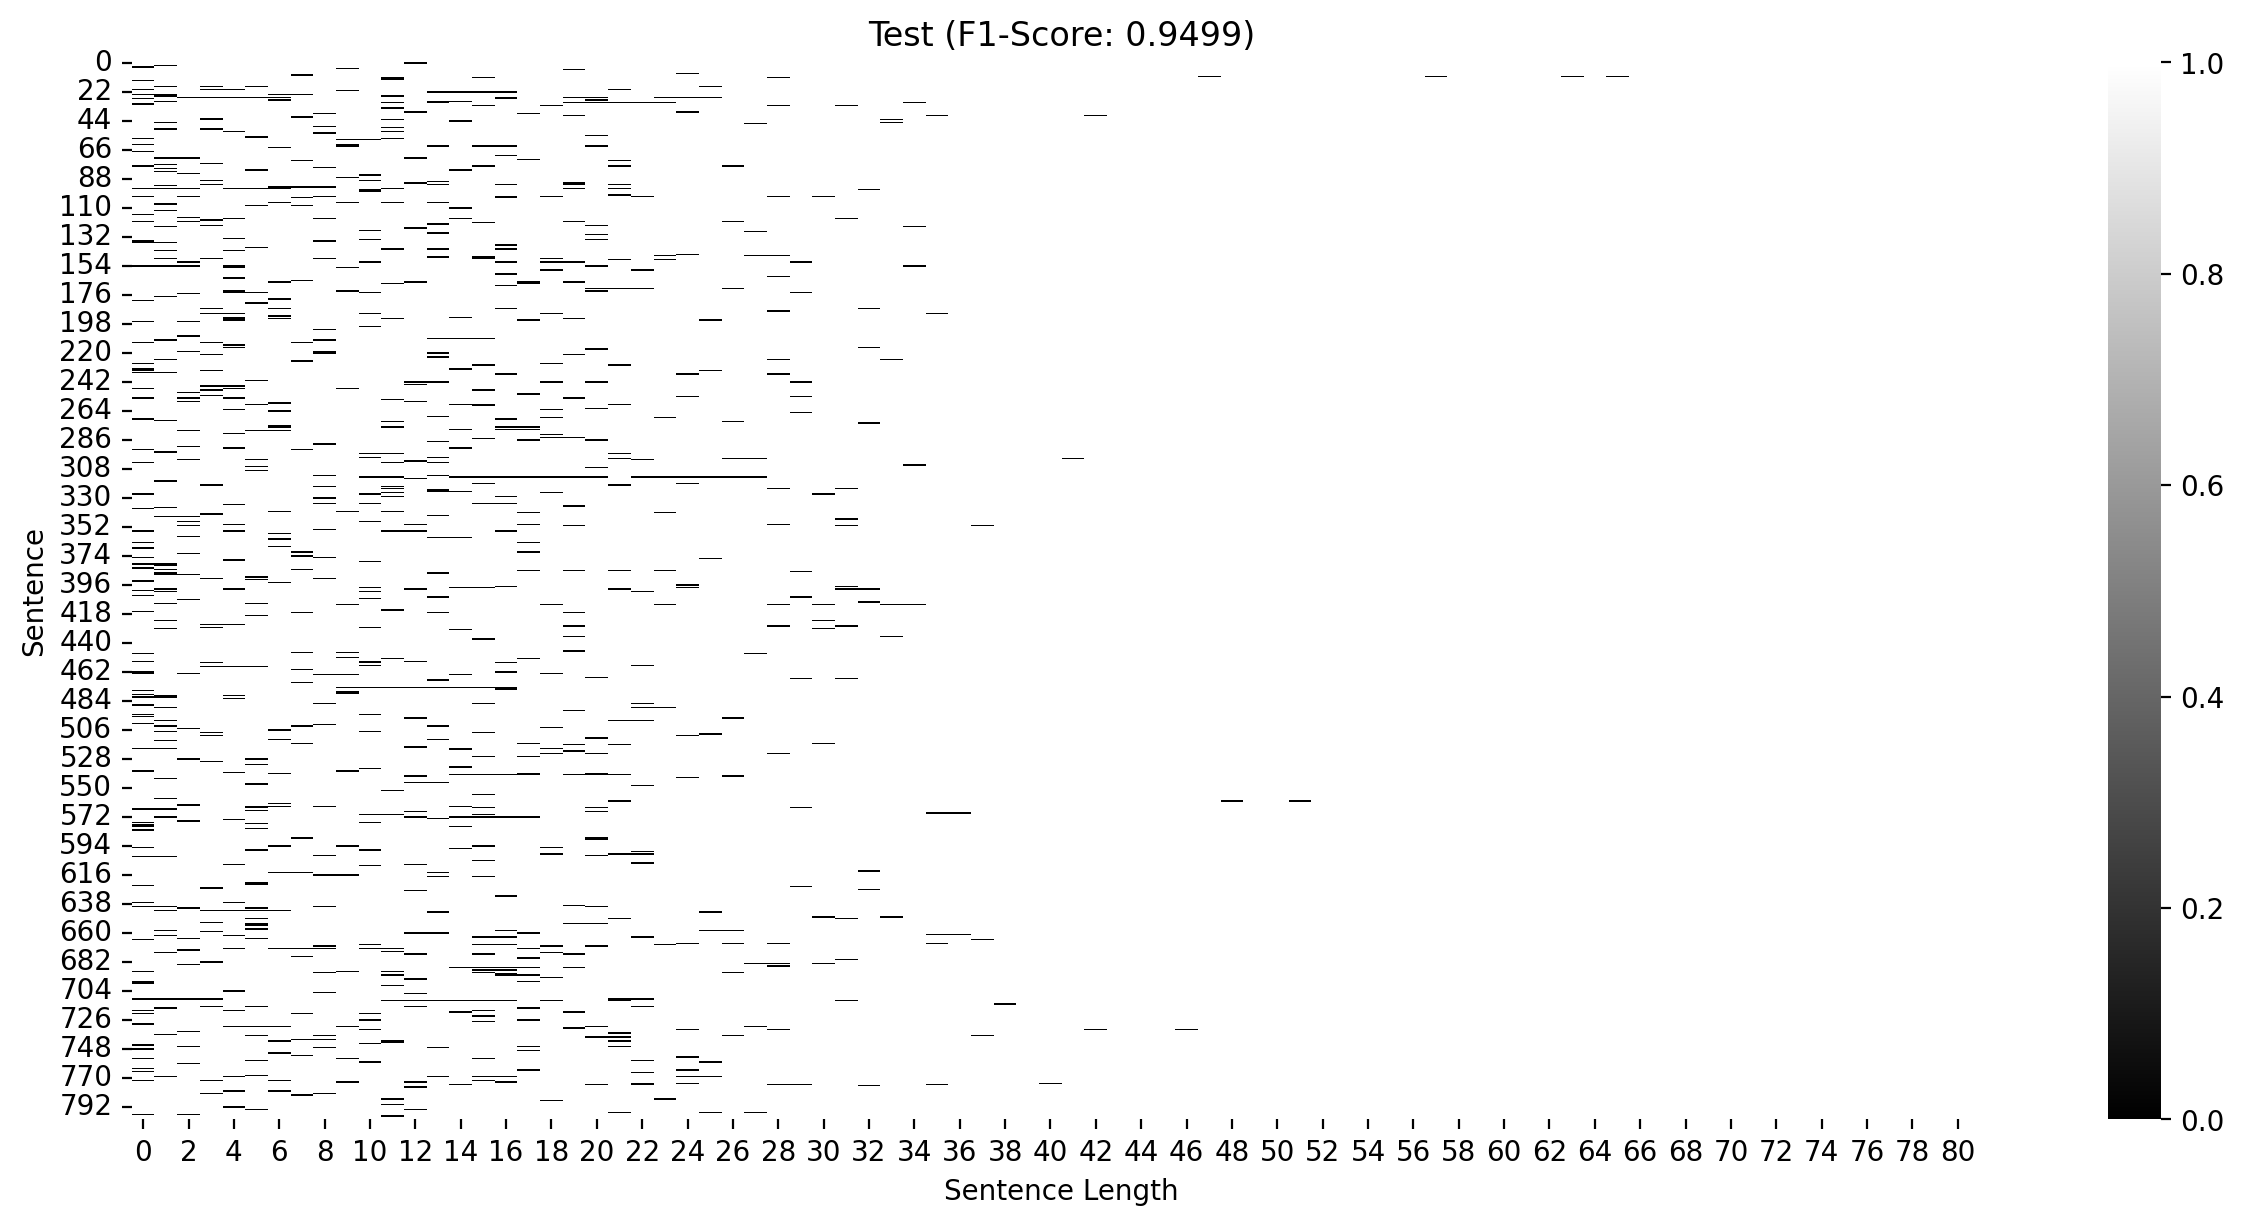

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


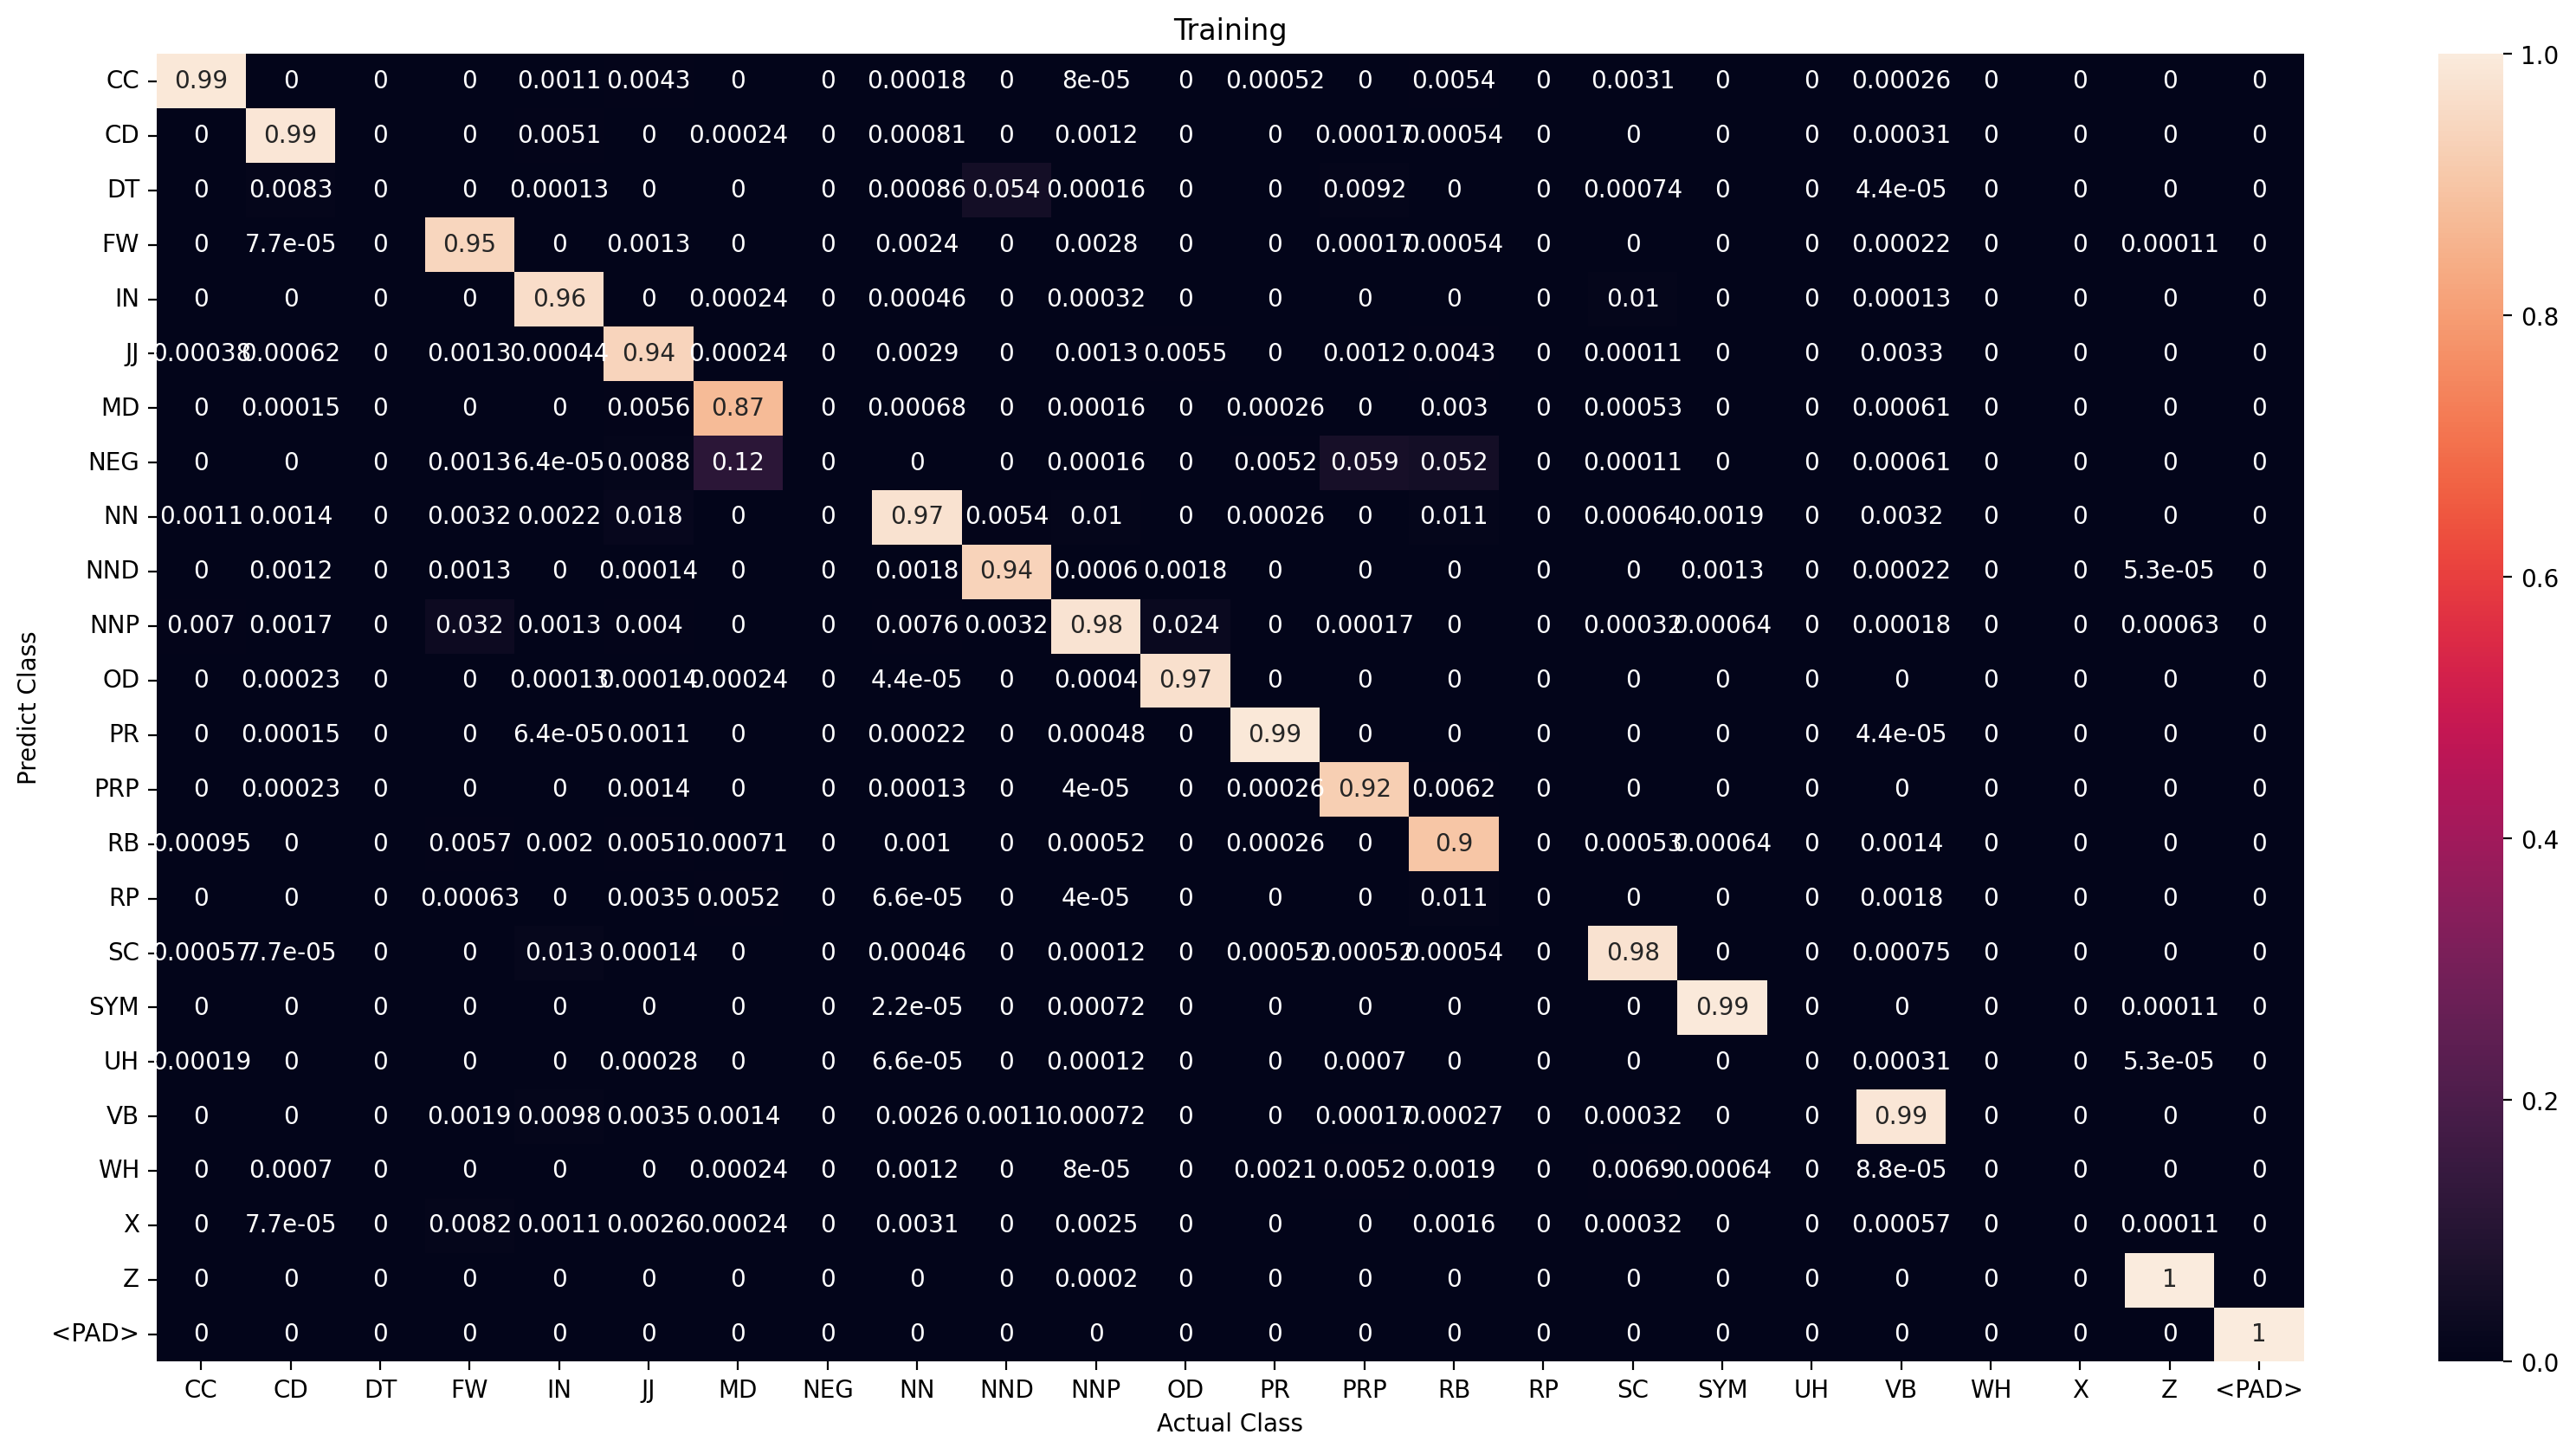

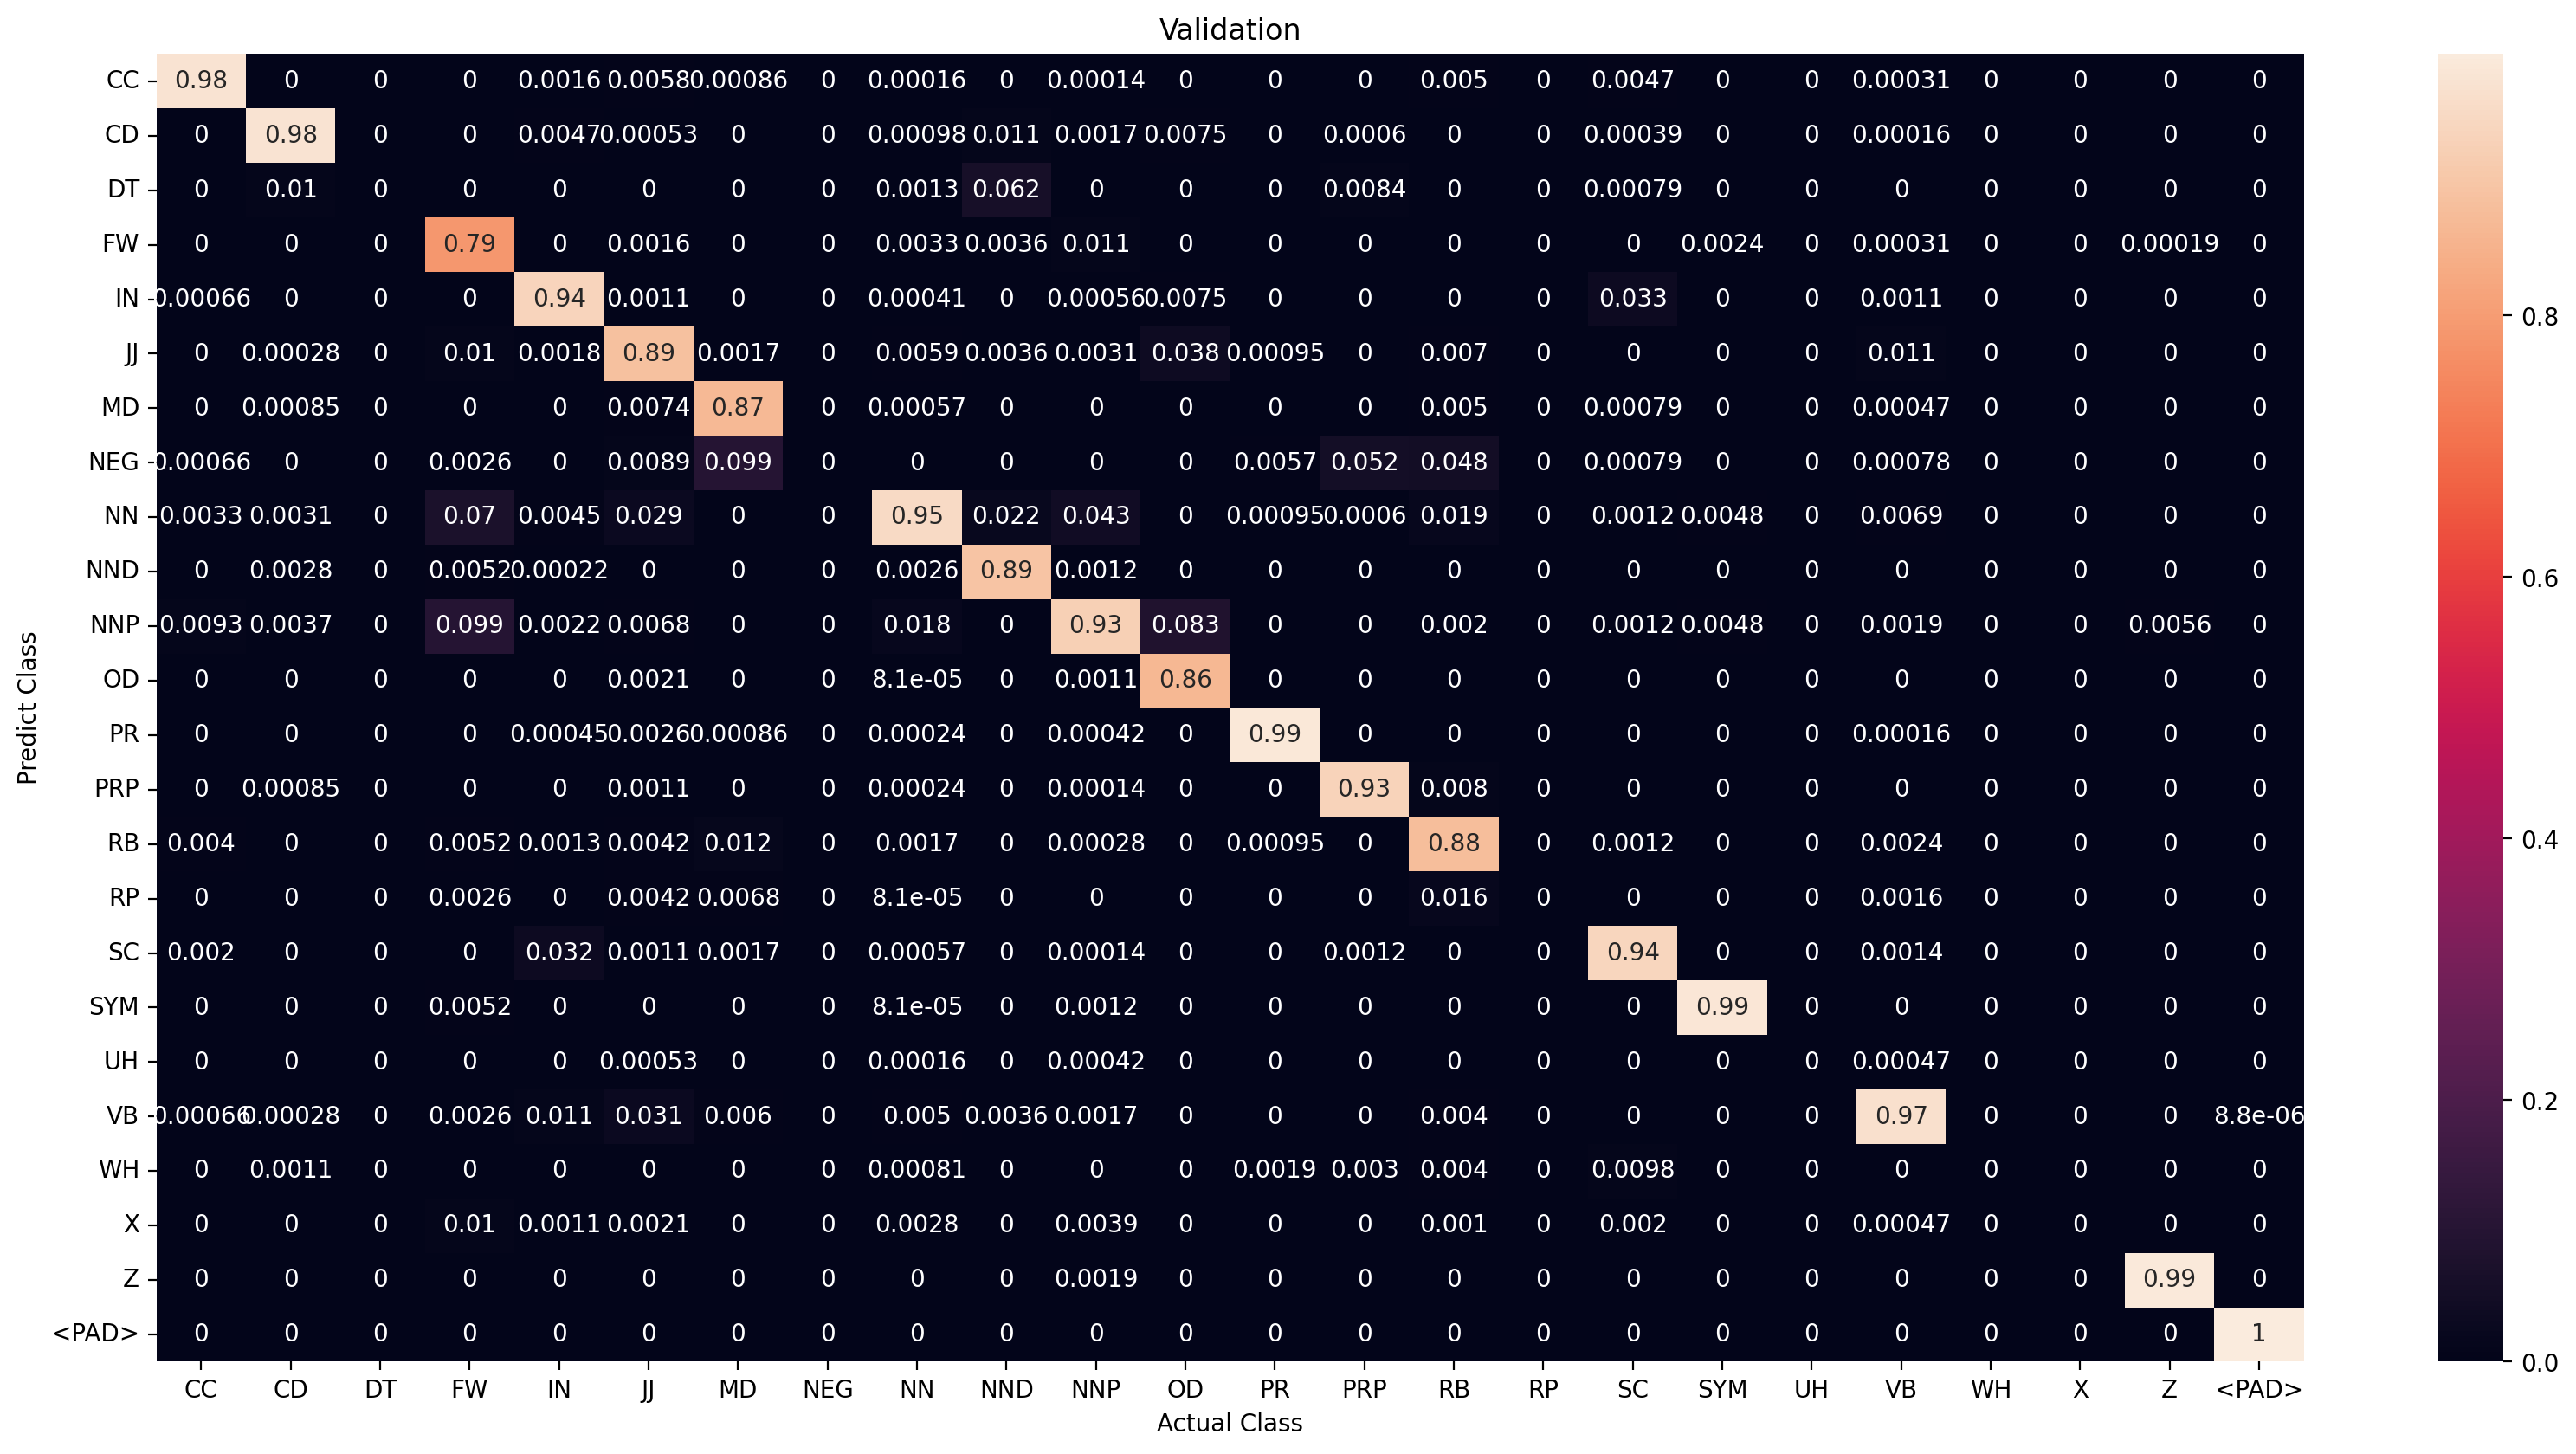

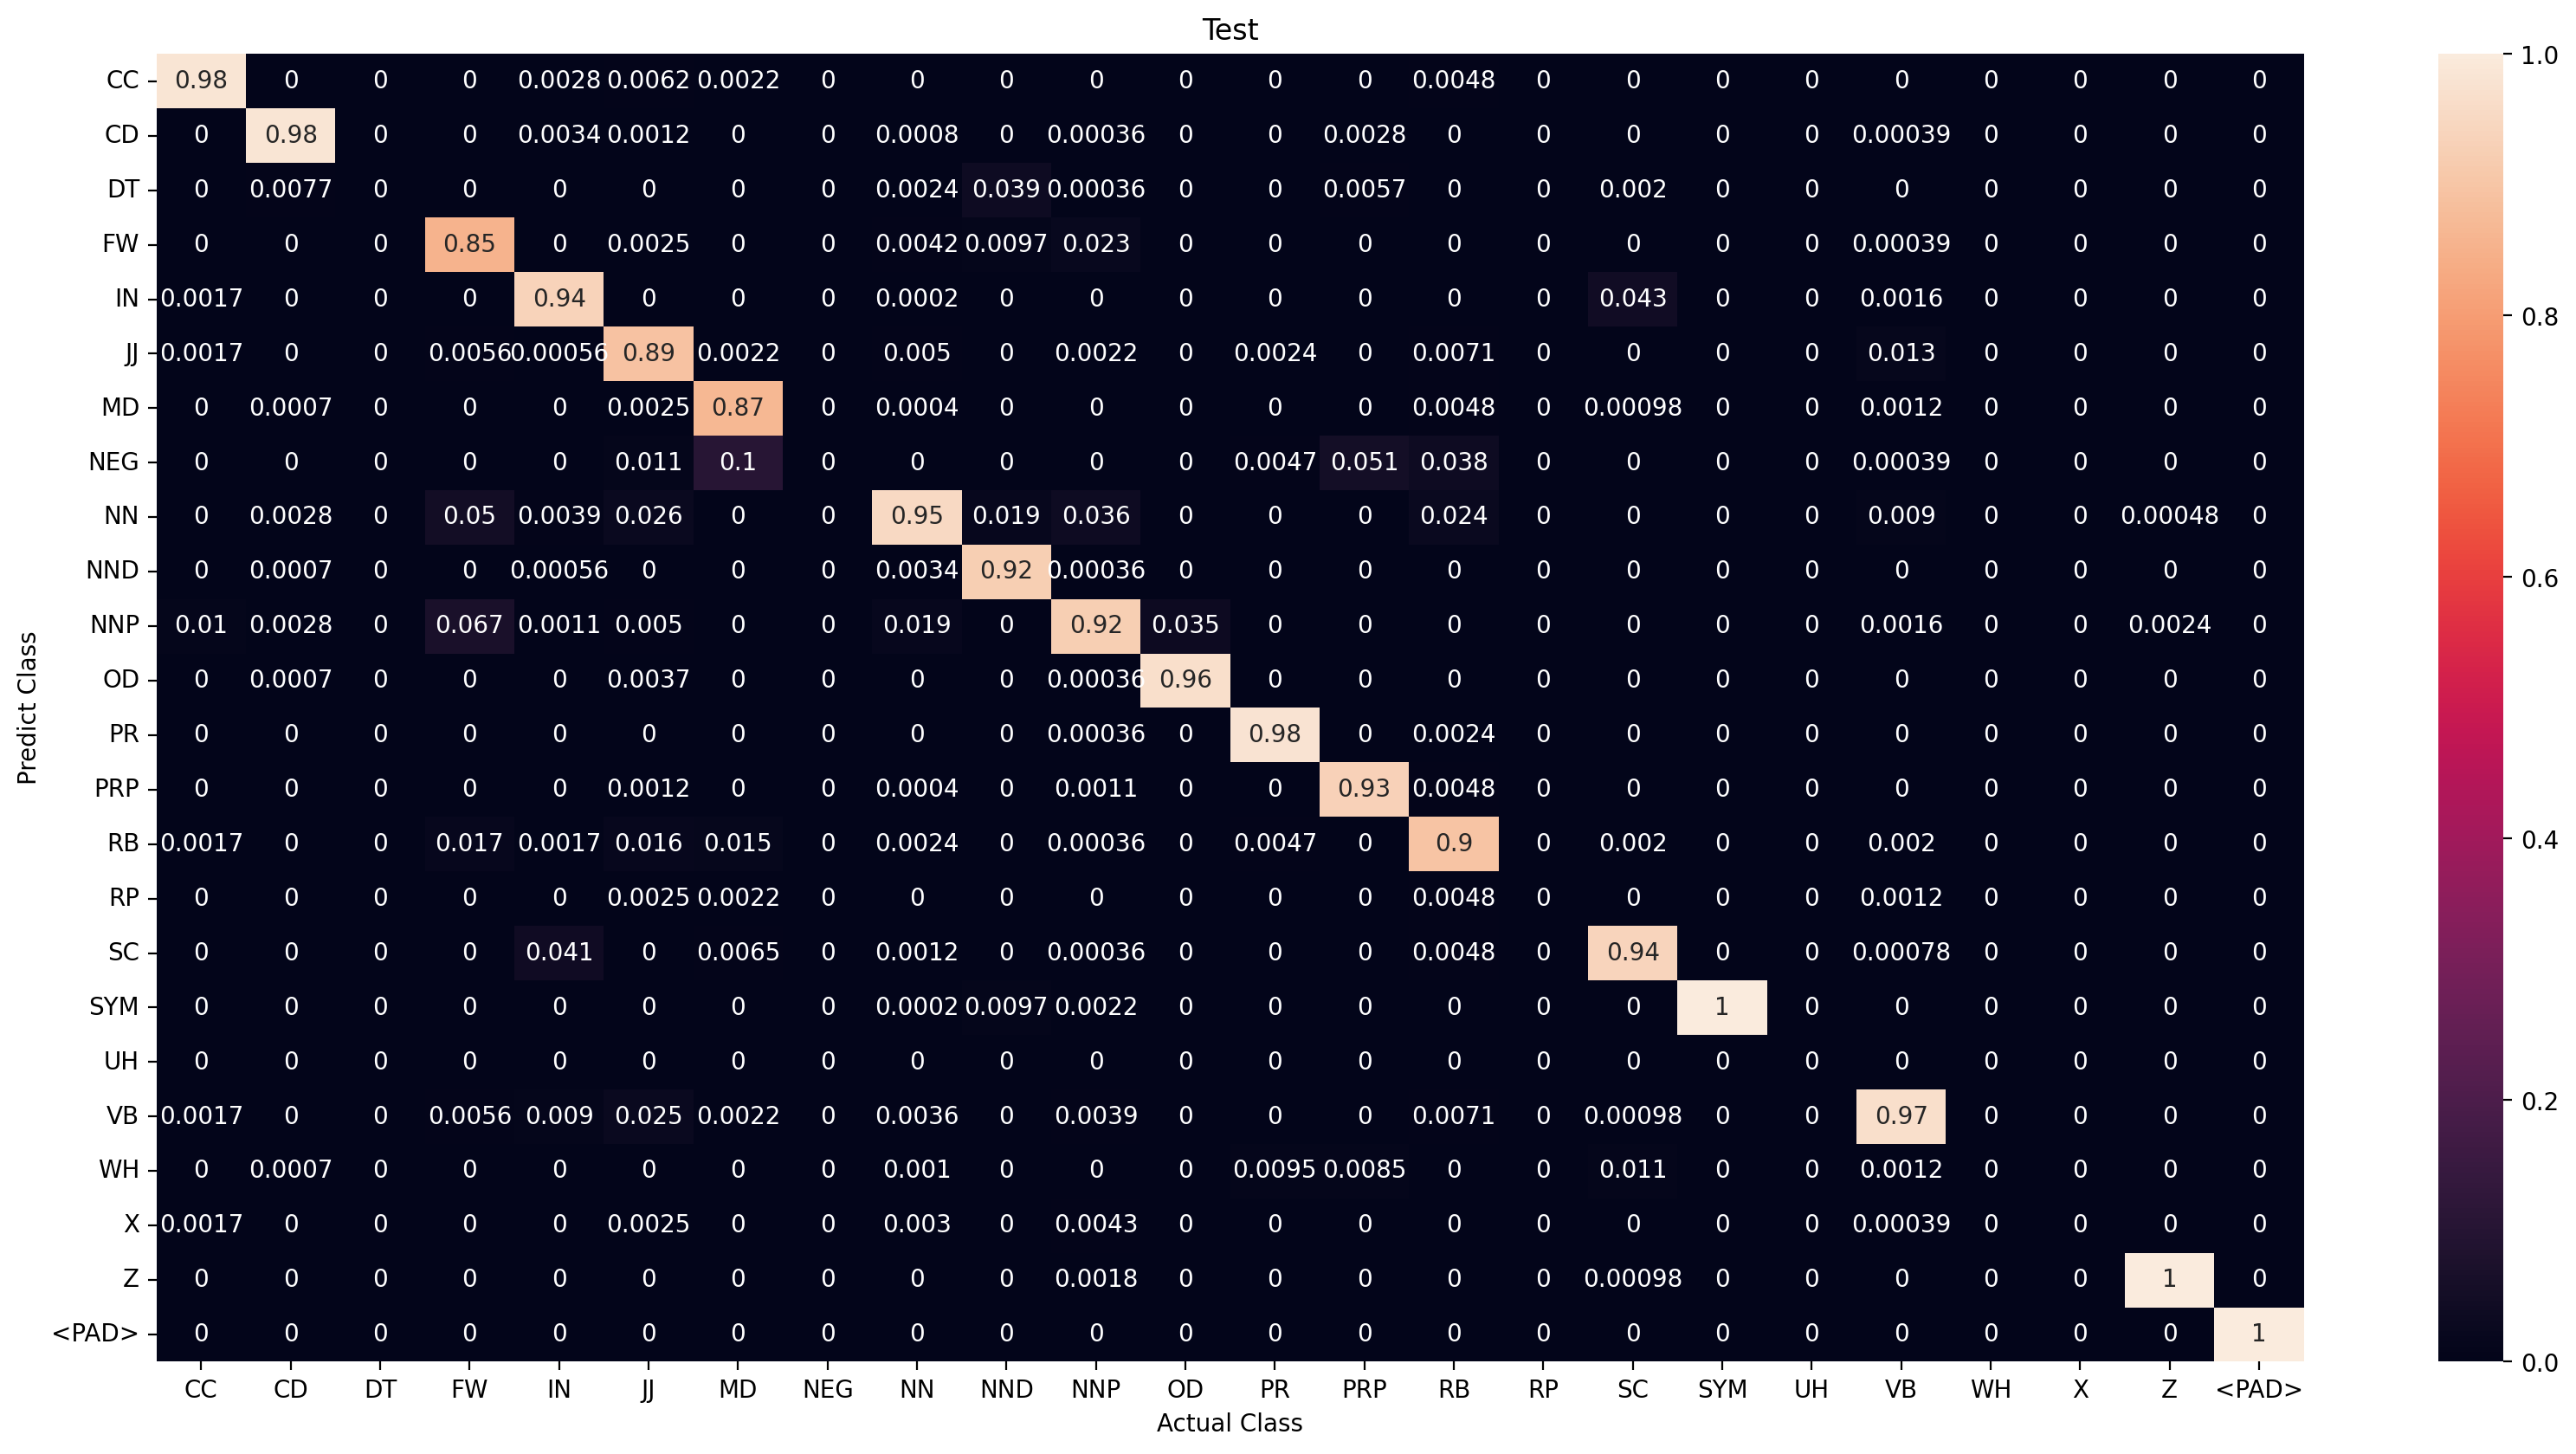

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5221       | CC    : 115      |
| CD    : 12904  | CD    : 12745      | CD    : 159      |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1499       | FW    : 198      |
| IN    : 15290  | IN    : 15162      | IN    : 128      |
| JJ    : 7049   | JJ    : 6764       | JJ    : 285      |
| MD    : 3783   | MD    : 3675       | MD    : 108      |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44200      | NN    : 569      |
| NND   : 998    | NND   : 874        | NND   : 124      |
| NNP   : 24884  | NNP   : 24345      | NNP   : 539      |
| OD    : 550    | OD    : 531        | OD    : 19       |
| PR    : 3878   | PR    : 3844       | PR    : 34       |
| PRP   : 5355   | PRP   : 5311       | PRP   : 44       |
| RB    : 3517   | RB    : 3334       | RB    : 183      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11383
Wrong prediction            : 551
Percentage correct oov pred : 95.38293950058656

Validation
Number OOV token            : 3261
Correct prediction          : 2980
Wrong prediction            : 281
Percentage correct oov pred : 91.38301134621281

Test
Number OOV token            : 1367
Correct prediction          : 1242
Wrong prediction            : 125
Percentage correct oov pred : 90.8558888076079



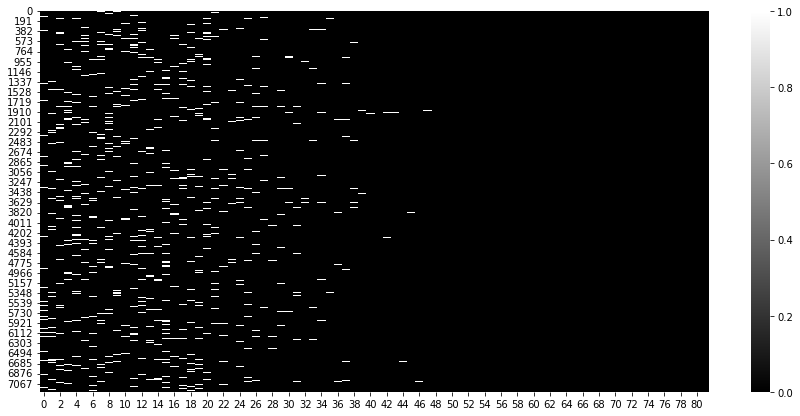

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

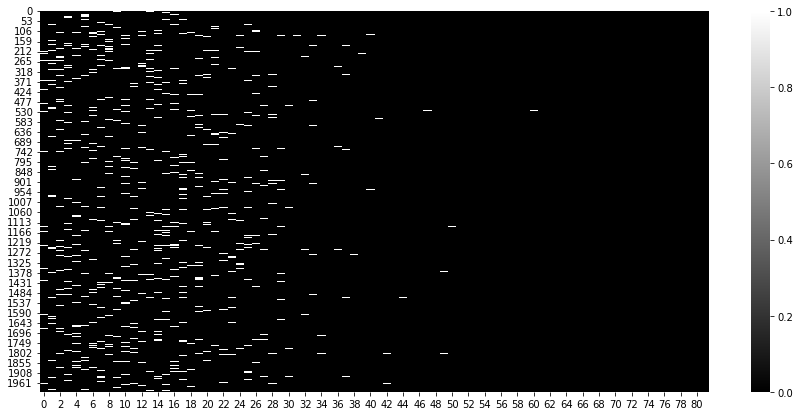

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

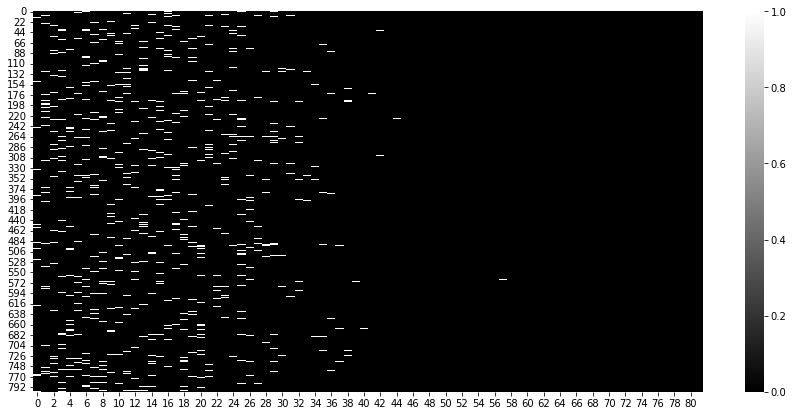

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);